## 1. Метрики качества в задачах классификации ч.2

In [1]:
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5, palette='Set2')

Для дальнейшего изучения метрик качества возьмем сгенерируем выборку при помощи `make_blobs` из `sklearn` и обучим логистическую регрессию:

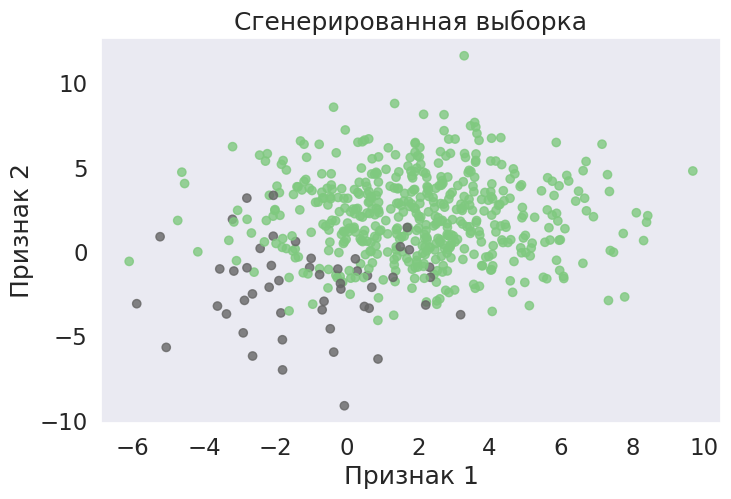

In [2]:
X, y = make_blobs(n_samples=(500, 50), centers=[[2, 2], [-2, -2]], 
                  cluster_std=2.5, random_state=42)

plt.figure(figsize=(8, 5))
plt.title('Сгенерированная выборка')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.grid()
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [4]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

### B. Площадь под ROC-кривой (Area Under ROC Curve, AUC-ROC)

[AUC-ROC в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc)
 
При переводе вещественнозначного ответа модели (например, в логистической регрессии, вероятности принадлежности к классу $1$) в бинарную метку {$0$, $1$}, мы должны выбрать порог перехода. Обычно, таким порогом является $0.5$, но такой выбор не всегда является оптимальным, например, при отсутствии балансов классов.

Ранее изученные метрики (precision, recall, accuracy) характеризуют точность работы модели при конкретно выбранном пороге $t$ бинарной классификации.

Одним из способов оценить модель в целом, не привязываясь к конкретному порогу, является **AUC-ROC**. Данная кривая представляет из себя кривую от $(0,0)$ до $(1,1)$ в координатах **True Positive Rate (TPR)** и **False Positive Rate (FPR)**.

Для понимания того, что такое TPR и FPR вспомним матрицу ошибок:

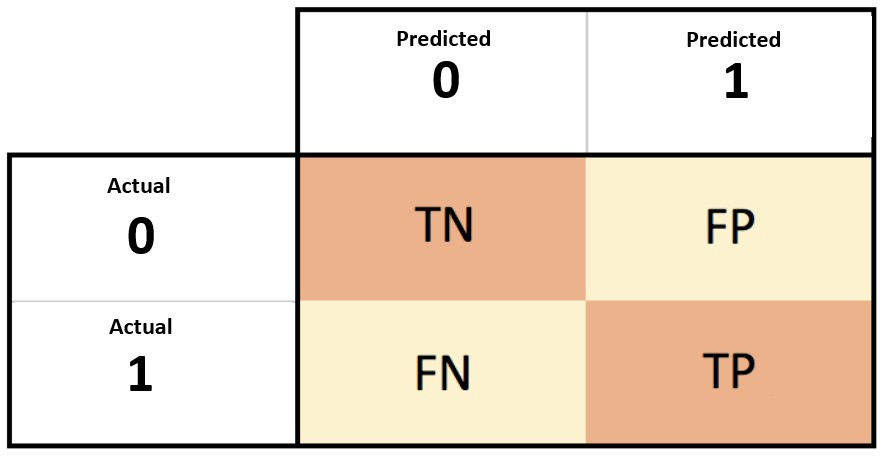

В приведенной ниже терминологии мы считаем класс с меткой $1$ положительным, а с меткой $0$ &mdash; негативным

**TPR (True Positive Rate, полнота)** показывает какую долю объектов положительного класса модель классифицировала правильно:

$$TPR = \dfrac{TP}{TP + FN}$$


**FPR (False Positive Rate)** показывает, какую долю из объектов негативного класса модель предсказала неверно:

$$FPR = \dfrac{FP}{FP + TN}$$


Каждая точка на графике соответствует выбору некоторого порога бинарной классификации $t$. 

Кривая рисуется следующим образом:
- мы перебираем пороги, начиная с $1$ и до $0$.
- При $t = 1$ всем объектам присваивается класс $0$, значит мы находимся в точке $(0, 0)$
- уменьшаем $t$ до тех пор пока TPR и FPR не изменяются. Когда изменились, отмечаем точку (FPR , TPR) на графике
- продолжаем алгоритм до тех пор, пока все точки не будут рассмотрены

Площадь под кривой в данном случае показывает качество модели: чем она больше, тем классификатор лучше.


Также важным является крутизна самой кривой &mdash; мы хотим максимизировать TPR, минимизируя FPR, а значит, наша кривая в идеале должна стремиться к точке $(0,1)$.

В идеальном случае, когда классификатор не делает ошибок (FPR = $0$, TPR = $1$) мы получим площадь под кривой, равную единице:

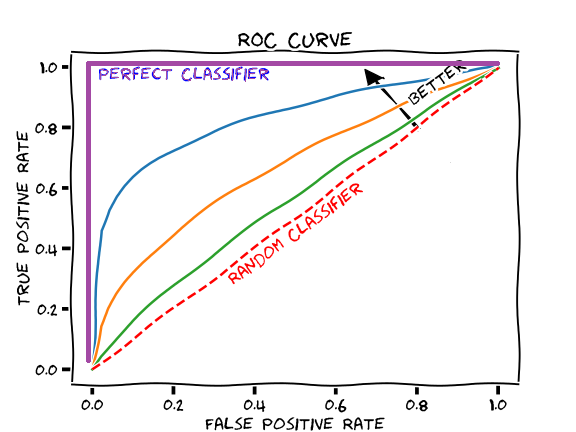

Заметим также, что FPR и TPR нормируются на размеры классов, поэтому AUC-ROC не поменяется при изменении баланса классов.

**AUC-ROC через упорядоченные/неупорядоченные пары**

Пусть в нашей тестовой выборке $n$ объектов класса $0$ и $m$ объектов класса $1$. Тогда представим квадрат $[0, 1] \times [0, 1]$ в виде прямоугольной сетки из $m \times n$ блоков.

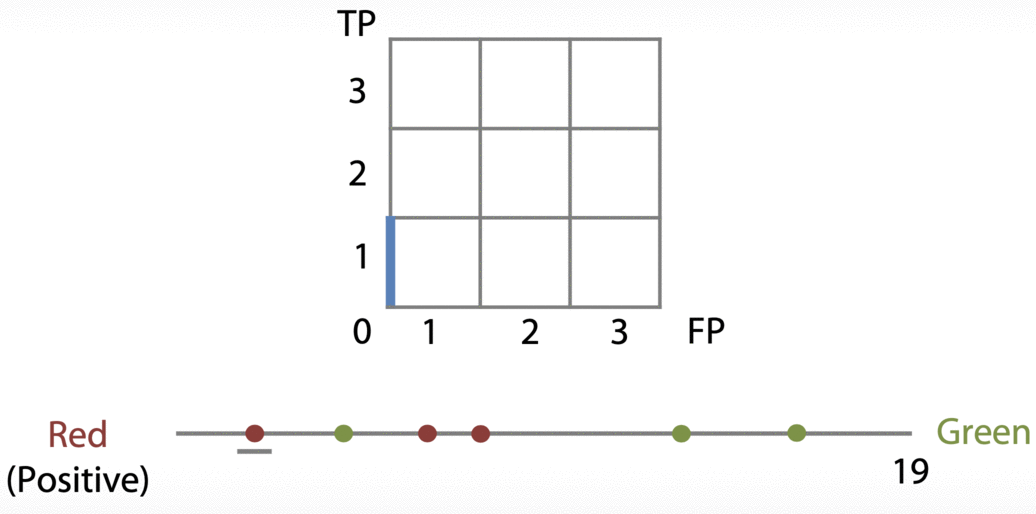

Тогда каждый блок ниже синей линии соответствует паре (объект класса $1$, объект класса $0$), для которой наш алгоритм правильно предсказал порядок (объект класса $1$ получил оценку выше, чем объект класса $0$), блок выше синей линии &mdash; паре, на которой ошибся.

В случае правильного порядка всех пар AUC-ROC будет равен $1$.

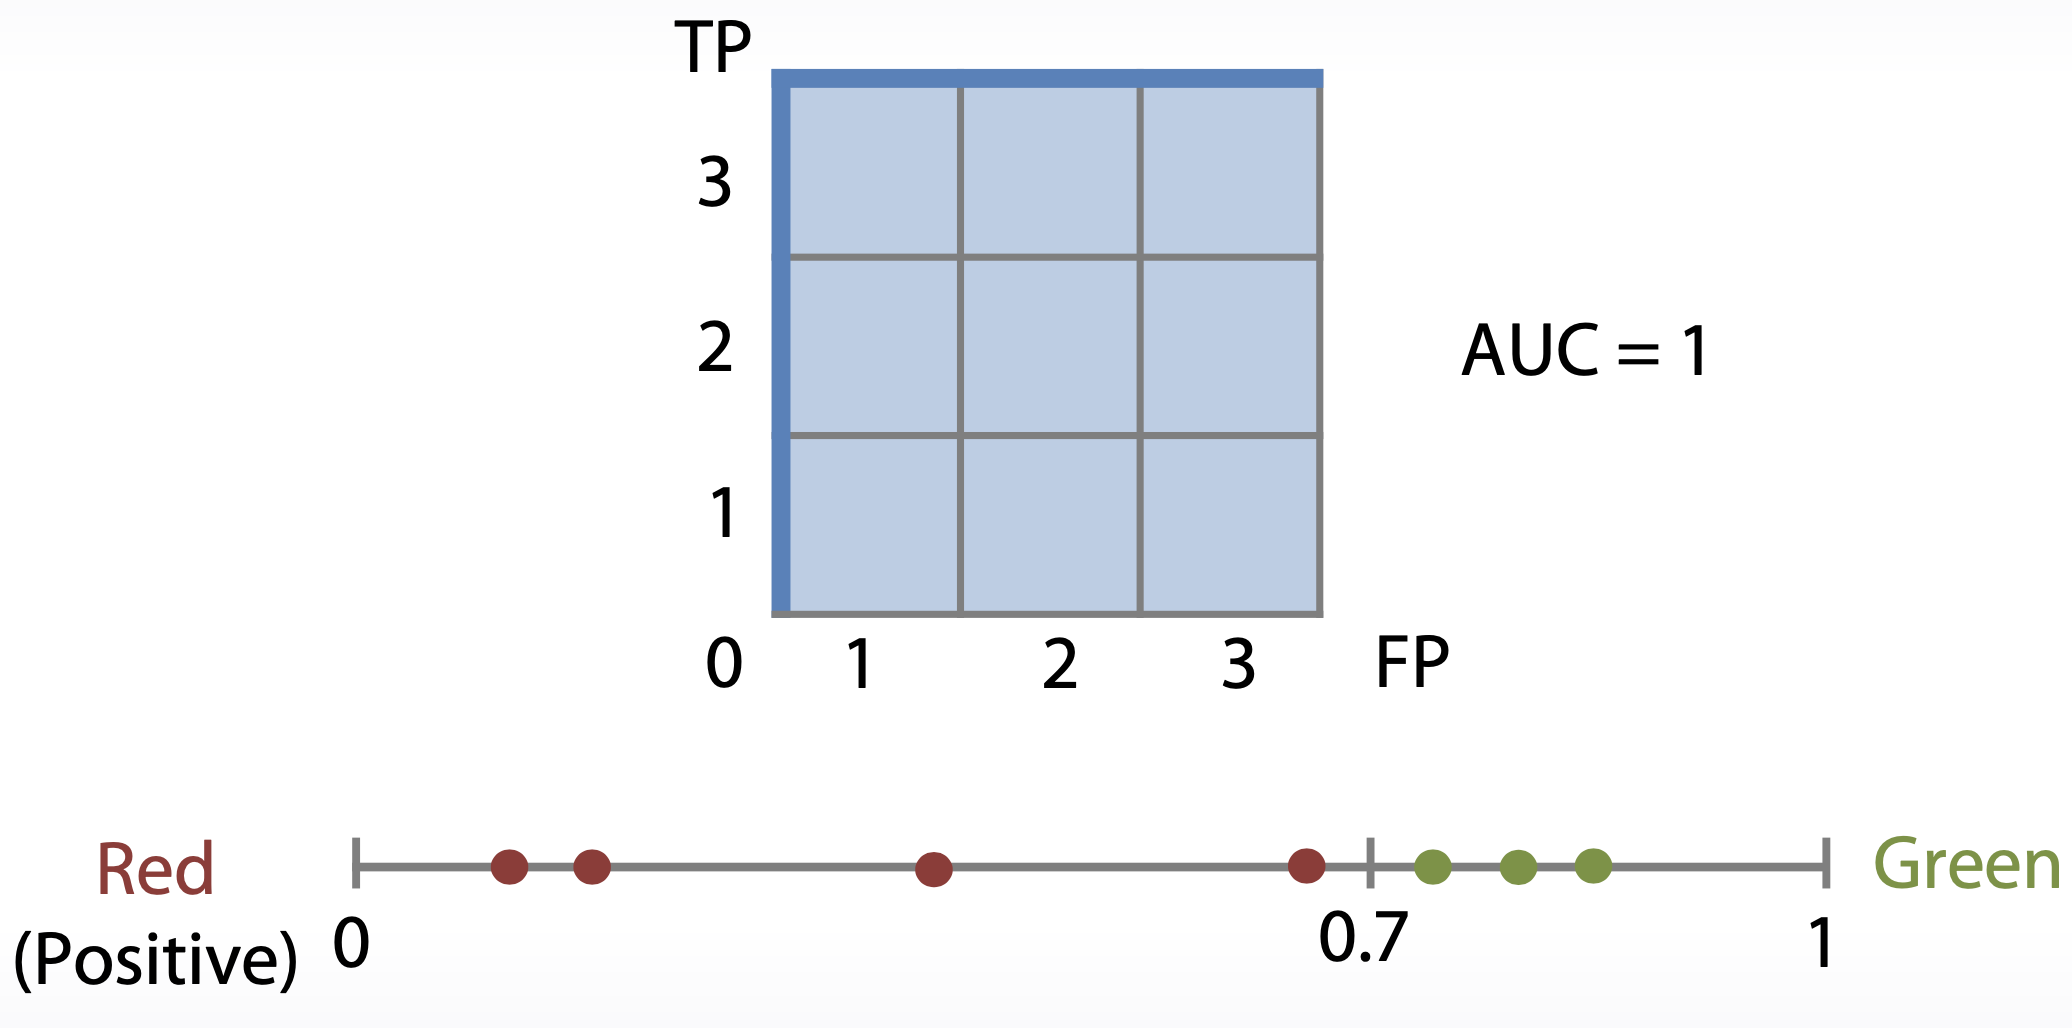

AUC-ROC может быть записан через количество правильно упорядоченных пар.

Эта формула игнорирует случаи, когда объекты разных классов находятся в одной точке. В такой ситуации считаем, что пара дает вклад $1/2$.

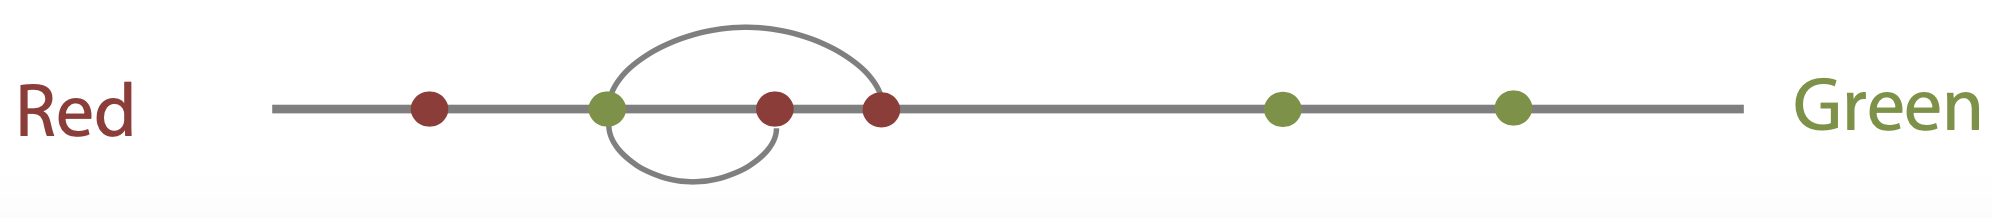

Такое альтернативое определение позволяет нам взглянуть на AUC-ROC, как на метрику ранжирования.

Посчитаем AUC-ROC для нашей задачи:

In [5]:
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f'AUC-ROC: {roc_auc:.3f}')

AUC-ROC: 0.929


Отрисуем ROC-кривую:

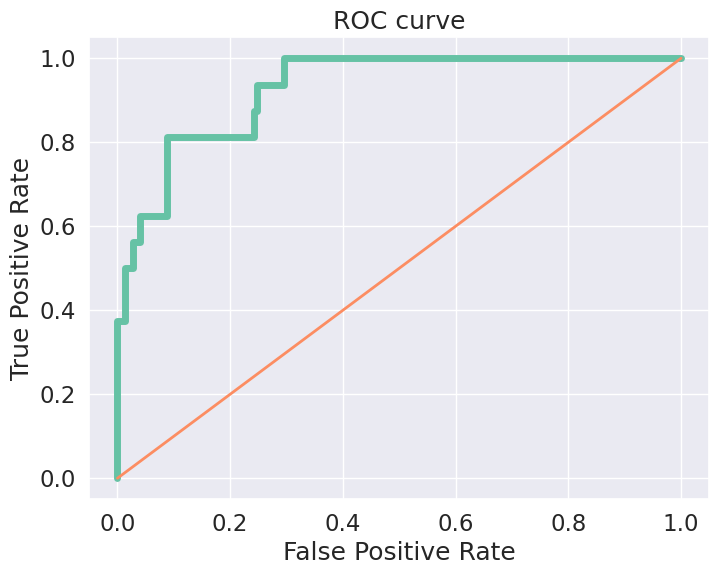

In [6]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=5, label='ROC curve')
plt.plot([0, 1], [0, 1], lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### Алгоритм подсчета

Рассмотрим алгоритм подсчета AUC-ROC за $O(n \log n)$.

Имеем: 
* ответы: $y_1, \dots, y_n$;
* выходы модели: $p_1, \dots, p_n$.

Введем:
* $m_{+} = TP + FN$;
* $m_{-} = FP + TN$.

Упорядочим вероятности $O(n \log n)$:

$$
p_1, \dots, p_n \rightarrow p_{(n)}, \dots, p_{(1)}.
$$

Применим эту же перестановку к $y_1, \dots, y_n$.

Теперь опишем алгоритм $O(n)$. 


```python
FPR = [0]*(n+1)
TRP = [0]*(n+1)
AUC = 0
for i in range(1, n+1):
    if y[i-1] == 1:
        FPR[i] = FPR[i-1]
        TPR[i] = TPR[i-1] + 1/m_plus
    else:
        FPR[i] = FPR[i-1] + 1/m_minus
        TPR[i] = TPR[i-1]
        AUC += 1/m_minus * TPR[i]
```

Стоит сразу отметить, что это упрощенная версия, которая не умеет обрабатывать корректно случаи, когда одному значению $p$ соответствует сразу множество точек. В таком ситуации нам следует шагать "по диагонали" как будто мы сразу обработали все эти точки за один раз.

### C. Площадь под PR-кривой (Area Under PR Curve, AUC-PR)

[AUC-PR в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve)

Аналогично ROC-кривой, определим PR-кривую как кривую в координатах recall  и precision, начинающуюся в точке $(0, 0)$.

Каждая точка на графике соответствует выбору некоторого порога бинарной классификации $t$. Площадь под кривой в данном случае показывает качество модели: чем она больше, тем классификатор лучше.

При построении кривой перебираем порог от $1$ до $0$. Как только precision или recall меняется, наносим точку на график. <br>
При пороге $t=1$: recall = $0$, precision = $0$<br>
При пороге $t=0$: recall = $1$, precision = $TP / (TP + FP)$ (может как быть 1, так и быть меньше)<br>

>*Замечание.* 
>
>На графиках кажется, что кривая начинается из точки $(0, 1)$. Это связано с тем, что если $t$ находится в окрестности $1$, но при этом не равно $1$, то precision скорей всего будет большим и близким к единице. Более того, многие стандартные методы отрисовки PR-кривой пропускают точку $t = 1$ и начинают отрисовку со следующего значения $t$.

Также важным является "пологость" самой кривой &mdash; мы хотим максимизировать и precision и recall, а значит, наша кривая в идеале должна стремиться к точке $(1,1)$.

В идеальном случае, когда классификатор не делает ошибок (precision=$1$,  recall=$1$) мы получим площадь под кривой, равную единице:

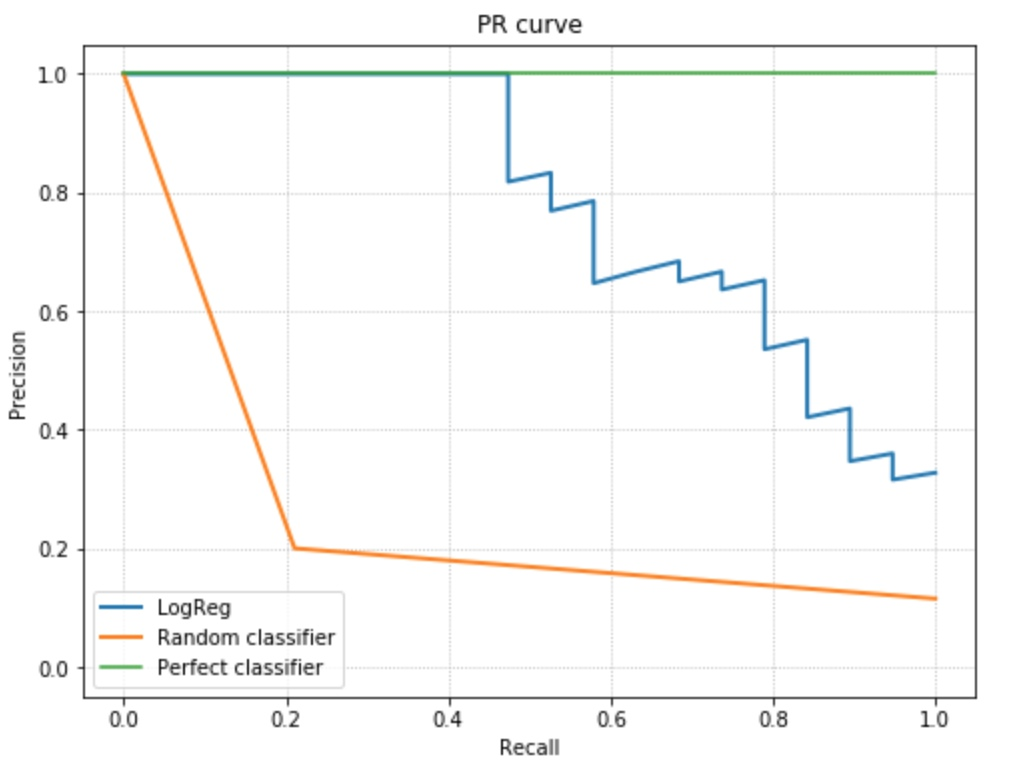

Отрисум AUC-PR для нашей задачи:

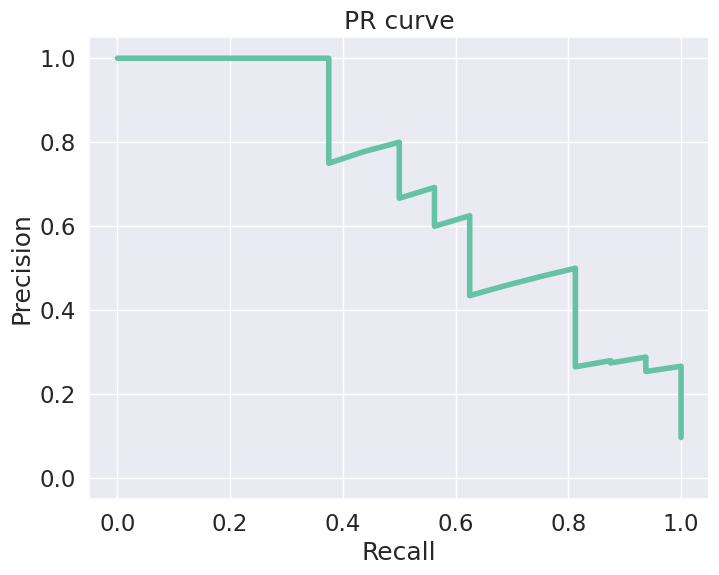

In [8]:
precisions, recalls, thresholds = precision_recall_curve(
    y_test, clf.predict_proba(X_test)[:,1]
)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, lw=4, label='PR curve')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

А также посчитаем площадь под данной PR-кривой, воспользовавшись функцией `auc`, которая считает площадь под кривыми с помощью метода трапеций:

In [9]:
auc_pr = auc(recalls, precisions)
print(f'AUC-PR: {auc_pr:.3f}')

AUC-PR: 0.692


Или же используя формулу для **Average precision**:

$$AP = \sum\limits_n (R_n - R_{n - 1}) P_n, $$ 

где $P_n$ и $R_n$ &mdash; precision и recall соответственно для $n$-ого порога классификации

In [10]:
average_precision = average_precision_score(
    y_test, clf.predict_proba(X_test)[:, 1]
)
print(f'Average precision: {average_precision:.3f}')

Average precision: 0.698


Полезные материалы:

[Связь между AUC-ROC и AUC-PR](http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf)

[Визуализация AUC-ROC](http://www.navan.name/roc/)